In [2]:
from geosyspy import Geosys
import os
from dotenv import load_dotenv
import datetime as dt
from dateutil.relativedelta import relativedelta
import logging
from geosyspy.utils.constants import *
from IPython.display import Image, display

logger = logging.getLogger('geosyspy')
logger.setLevel(logging.DEBUG)

# read .env file
load_dotenv()

API_CLIENT_ID = os.getenv('API_CLIENT_ID')
API_CLIENT_SECRET = os.getenv('API_CLIENT_SECRET')
API_USERNAME = os.getenv('API_USERNAME')
API_PASSWORD = os.getenv('API_PASSWORD')

client = Geosys(API_CLIENT_ID, API_CLIENT_SECRET, API_USERNAME, API_PASSWORD, Env.PREPROD, Region.NA)

polygon = "POLYGON((-91.17523978603823 40.29787117039518,-91.17577285022956 40.29199489606421,-91.167613719932 40.29199489606421,-91.1673028670095 40.29867040193312,-91.17523978603823 40.29787117039518))"
today = dt.date.today()
year_ago = dt.date.today() + relativedelta(months=-12)

# available crop codes of the connected user
crops = client.get_available_crops()


2024-06-14 11:18:20,153 - geosyspy.utils.oauth2_client - INFO - Authenticated


In [3]:
# Get coverage for the polygon
coverage_info_df, images_references = client.get_satellite_coverage_image_references(year_ago, today, collections=[SatelliteImageryCollection.SENTINEL_2, SatelliteImageryCollection.LANDSAT_8, SatelliteImageryCollection.LANDSAT_9],polygon=polygon)
coverage_info_df

2024-06-14 11:18:21,028 - geosyspy.services.map_product_service - INFO - Calling APIs for coverage


,coveragePercent,maps,image.id,image.availableBands,image.sensor,image.spatialResolution,image.date,seasonField.id
0,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'CVI'}...",sentinel-2-l2a|S2A_15TXE_20240606_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-06-06T17:02:38Z,None
1,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'CVI'}...",landsat-c2l2-sr|LC09_L2SP_024032_20240528_2024...,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",LANDSAT_9,30.0,2024-05-28T16:41:01Z,None
2,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'CVI'}...",sentinel-2-l2a|S2B_15TXE_20240512_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-05-12T17:02:32Z,None
3,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'CVI'}...",landsat-c2l2-sr|LC09_L2SP_024032_20240512_2024...,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",LANDSAT_9,30.0,2024-05-12T16:41:14Z,None
4,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'CVI'}...",sentinel-2-l2a|S2B_15TXE_20240412_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-04-12T17:02:33Z,None
5,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'CVI'}...",sentinel-2-l2a|S2A_15TXE_20240407_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-04-07T17:02:31Z,None
6,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'CVI'}...",sentinel-2-l2a|S2A_15TXE_20240328_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-03-28T17:02:33Z,None
7,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'CVI'}...",sentinel-2-l2a|S2B_15TXE_20240323_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-03-23T17:02:33Z,None
8,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'CVI'}...",landsat-c2l2-sr|LC09_L2SP_024032_20240309_2024...,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",LANDSAT_9,30.0,2024-03-09T16:41:51Z,None
9,100.0,"[{'type': 'COLORCOMPOSITION'}, {'type': 'CVI'}...",sentinel-2-l2a|S2B_15TXE_20240303_0_L2A,"[Blue, Green, Red, Nir, Swir1, Swir2, CoastalB...",SENTINEL_2,10.0,2024-03-03T17:02:29Z,None


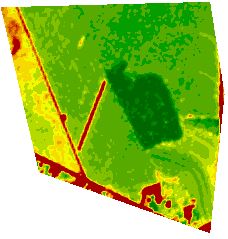

In [4]:
# get product from coverage
season_field_id = 'y3mxlxx'
image_id = 'sentinel-2-l2a|S2B_21JYM_20240429_0_L2A'
indicator = 'INSEASON_NDVI'
image_extension = ".png"
product = client.get_product(season_field_id, image_id, indicator, image_extension)
if image_extension is not None:
    display(Image("output" + image_extension))
else:
    display(product)

In [5]:
# Get aggregated NDVI time series
client.get_time_series(year_ago, today, collection=SatelliteImageryCollection.MODIS, indicators=["NDVI"],polygon=polygon)

2024-06-14 11:18:23,405 - geosyspy.services.vegetation_time_series_service - INFO - Calling APIs for aggregated time series
c:\Users\ajd\Documents\GitHub\GeosysPy\geosyspy\services\vegetation_time_series_service.py:57: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json.dumps(dict_response))


,index,value
date,,
2023-06-14,NDVI,0.642264
2023-06-15,NDVI,0.652966
2023-06-16,NDVI,0.663388
2023-06-17,NDVI,0.673508
2023-06-18,NDVI,0.683310
...,...,...
2024-06-09,NDVI,0.485644
2024-06-10,NDVI,0.494038
2024-06-11,NDVI,0.504215


In [6]:
# Get aggregated EVI time series
client.get_time_series(year_ago, today, collection=SatelliteImageryCollection.MODIS, indicators=["EVI"], polygon=polygon)

2024-06-14 11:18:25,268 - geosyspy.services.vegetation_time_series_service - INFO - Calling APIs for aggregated time series
c:\Users\ajd\Documents\GitHub\GeosysPy\geosyspy\services\vegetation_time_series_service.py:57: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json.dumps(dict_response))


,index,value
date,,
2023-06-14,EVI,0.443899
2023-06-15,EVI,0.450635
2023-06-16,EVI,0.457103
2023-06-17,EVI,0.463278
2023-06-18,EVI,0.469148
...,...,...
2024-06-09,EVI,0.324216
2024-06-10,EVI,0.331350
2024-06-11,EVI,0.339898


In [7]:
# Get aggregated 'Forecast daily' time series
indicators = ['Precipitation', 'Temperature','Date']
point = "POINT (0.0872845021171696 43.69457564315705)"
client.get_time_series(dt.date.today(), dt.date.today() + relativedelta(days=+5), collection=WeatherTypeCollection.WEATHER_FORECAST_DAILY, indicators=indicators,polygon=point)

,precipitation.cumulative,precipitation.probabilities,temperature.standard,Location
date,,,,
2024-06-14T00:00:00Z,0.149606,90.0,65.786,POINT (0.0872845021171696 43.69457564315705)
2024-06-15T00:00:00Z,0.070866,80.0,61.736,POINT (0.0872845021171696 43.69457564315705)
2024-06-16T00:00:00Z,0.000000,10.0,63.554,POINT (0.0872845021171696 43.69457564315705)
2024-06-17T00:00:00Z,0.039370,39.4,69.350,POINT (0.0872845021171696 43.69457564315705)
2024-06-18T00:00:00Z,0.232283,70.0,68.918,POINT (0.0872845021171696 43.69457564315705)
2024-06-19T00:00:00Z,0.385827,70.0,63.410,POINT (0.0872845021171696 43.69457564315705)


In [8]:
# Get aggregated 'Forecast hourly' time series
indicators = ['Precipitation', 'Temperature']
point = "POINT (0.0872845021171696 43.69457564315705)"
client.get_time_series(dt.date.today(), dt.date.today() + relativedelta(days=+2), collection=WeatherTypeCollection.WEATHER_FORECAST_HOURLY, indicators=indicators, polygon=point)

,precipitation.cumulative,precipitation.probabilities,temperature.standard,Location
date,,,,
2024-06-14T07:00:00Z,0.000000,14.6,62.87,POINT (0.0872845021171696 43.69457564315705)
2024-06-14T08:00:00Z,0.000000,10.0,65.03,POINT (0.0872845021171696 43.69457564315705)
2024-06-14T09:00:00Z,0.000000,10.0,67.55,POINT (0.0872845021171696 43.69457564315705)
2024-06-14T10:00:00Z,0.000000,18.2,70.07,POINT (0.0872845021171696 43.69457564315705)
2024-06-14T11:00:00Z,0.000000,17.8,71.87,POINT (0.0872845021171696 43.69457564315705)
2024-06-14T12:00:00Z,0.000000,18.1,73.49,POINT (0.0872845021171696 43.69457564315705)
2024-06-14T13:00:00Z,0.000000,10.0,74.03,POINT (0.0872845021171696 43.69457564315705)
2024-06-14T14:00:00Z,0.000000,0.0,75.29,POINT (0.0872845021171696 43.69457564315705)
2024-06-14T15:00:00Z,0.000000,22.3,75.83,POINT (0.0872845021171696 43.69457564315705)


In [9]:
# Get aggregated 'Historical daily' time series
indicators = ['Precipitation', 'Temperature']
start_date = dt.datetime.strptime("2022-01-01", "%Y-%m-%d")
end_date = dt.datetime.strptime("2022-02-01", "%Y-%m-%d")
client.get_time_series(start_date, end_date, collection=WeatherTypeCollection.WEATHER_HISTORICAL_DAILY, indicators=indicators,polygon=polygon)

,precipitation.cumulative,temperature.standard,Location
date,,,
2022-01-01T00:00:00Z,0.350394,24.386,POINT (-91.17139663702373 40.29511916279967)
2022-01-02T00:00:00Z,0.011811,6.008,POINT (-91.17139663702373 40.29511916279967)
2022-01-03T00:00:00Z,0.000000,13.874,POINT (-91.17139663702373 40.29511916279967)
2022-01-04T00:00:00Z,0.000000,30.776,POINT (-91.17139663702373 40.29511916279967)
2022-01-05T00:00:00Z,0.000000,15.548,POINT (-91.17139663702373 40.29511916279967)
2022-01-06T00:00:00Z,0.000000,4.460,POINT (-91.17139663702373 40.29511916279967)
2022-01-07T00:00:00Z,0.000000,4.586,POINT (-91.17139663702373 40.29511916279967)
2022-01-08T00:00:00Z,0.031496,25.574,POINT (-91.17139663702373 40.29511916279967)
2022-01-09T00:00:00Z,0.000000,19.238,POINT (-91.17139663702373 40.29511916279967)


In [10]:
# Get satellite image time series for Modis NDVI
client.get_satellite_image_time_series(year_ago, today, collections=[SatelliteImageryCollection.MODIS], indicators=["NDVI"], polygon=polygon)

2024-06-14 11:18:29,143 - geosyspy.services.vegetation_time_series_service - INFO - Calling APIs for time series by the pixel
2024-06-14 11:18:30,182 - geosyspy.services.vegetation_time_series_service - INFO - Computing X and Y coordinates per pixel... 
2024-06-14 11:18:30,199 - geosyspy.services.vegetation_time_series_service - INFO - Done ! 


,index,value,pixel.id,X,Y
date,,,,,
2023-06-14,NDVI,0.649486,mh11v4i222j4657,-6.620275e+06,-1.664613e+07
2023-06-14,NDVI,0.635043,mh11v4i221j4658,-6.620507e+06,-1.664636e+07
2023-06-15,NDVI,0.660745,mh11v4i222j4657,-6.620275e+06,-1.664613e+07
2023-06-15,NDVI,0.645188,mh11v4i221j4658,-6.620507e+06,-1.664636e+07
2023-06-16,NDVI,0.671886,mh11v4i222j4657,-6.620275e+06,-1.664613e+07
...,...,...,...,...,...
2024-06-11,NDVI,0.588776,mh11v4i221j4658,-6.620507e+06,-1.664636e+07
2024-06-12,NDVI,0.412464,mh11v4i222j4657,-6.620275e+06,-1.664613e+07
2024-06-12,NDVI,0.619886,mh11v4i221j4658,-6.620507e+06,-1.664636e+07


In [11]:
# Get satellite image time series for LANDSAT_8 and SENTINEL_2 Reflectance
time_series_xarr = client.get_satellite_image_time_series(year_ago, today, collections=[SatelliteImageryCollection.SENTINEL_2, SatelliteImageryCollection.LANDSAT_8], indicators=["Reflectance"],polygon=polygon)
time_series_xarr


2024-06-14 11:18:30,223 - geosyspy.services.map_product_service - INFO - Calling APIs for coverage
c:\Users\ajd\Documents\GitHub\GeosysPy\geosyspy\geosys.py:359: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_coverage["image.date"] = pd.to_datetime(
2024-06-14 11:18:48,887 - geosyspy.geosys - INFO - The highest resolution's image grid size is (72,76)
2024-06-14 11:18:48,932 - geosyspy.geosys - INFO - interpolating sentinel-2-l2a|S2B_15TXE_20240222_0_L2A to sentinel-2-l2a|S2B_15TXE_20240212_0_L2A's grid
2024-06-14 11:18:49,692 - geosyspy.geosys - INFO - interpolating sentinel-2-l2a|S2B_15TXE_20240303_0_L2A to sentinel-2-l2a|S2B_15TXE_20240212_0_L2A's grid
2024-06-14 11:18:49,743 - geosyspy.geosys - INFO - interpolating sentinel-2-l2a|S2B_15TXE_20240323_0_L2A to sentinel

<xarray.Dataset>
Dimensions:                  (band: 10, y: 76, x: 72, time: 13)
Coordinates:
  * band                     (band) <U11 'Blue' 'CoastalBlue' ... 'Swir2'
  * y                        (y) float64 40.3 40.3 40.3 ... 40.29 40.29 40.29
  * x                        (x) float64 -91.18 -91.18 -91.18 ... -91.17 -91.17
  * time                     (time) datetime64[ns] 2024-02-12T17:02:33 ... 20...
    image.id                 (time) <U59 'sentinel-2-l2a|S2B_15TXE_20240212_0...
    image.sensor             (time) <U10 'SENTINEL_2' ... 'LANDSAT_8'
    image.spatialResolution  (time) float64 10.0 10.0 10.0 ... 30.0 30.0 30.0
    crs                      (time) <U9 'EPSG:4326' 'EPSG:4326' ... 'EPSG:4326'
Data variables:
    reflectance              (time, band, y, x) float64 nan nan nan ... nan nan

In [12]:

import xarray as xr
# Get satellite image time series for LANDSAT_8 and SENTINEL_2 NDVI 
# list of available indicators: Reflectance, NDVI, EVI, GNDVI, NDWI, CVI, CVIn, LAI
ndvi_time_series_xarr = client.get_satellite_image_time_series(year_ago, today, collections=[SatelliteImageryCollection.SENTINEL_2, SatelliteImageryCollection.LANDSAT_8], indicators=["ndvi"], polygon=polygon)

ndvi_time_series_xarr


2024-06-14 11:18:50,392 - geosyspy.services.map_product_service - INFO - Calling APIs for coverage
c:\Users\ajd\Documents\GitHub\GeosysPy\geosyspy\geosys.py:359: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_coverage["image.date"] = pd.to_datetime(
2024-06-14 11:18:59,056 - geosyspy.geosys - INFO - The highest resolution's image grid size is (72,76)
2024-06-14 11:18:59,087 - geosyspy.geosys - INFO - interpolating sentinel-2-l2a|S2B_15TXE_20240222_0_L2A to sentinel-2-l2a|S2B_15TXE_20240212_0_L2A's grid
2024-06-14 11:18:59,134 - geosyspy.geosys - INFO - interpolating sentinel-2-l2a|S2B_15TXE_20240303_0_L2A to sentinel-2-l2a|S2B_15TXE_20240212_0_L2A's grid
2024-06-14 11:18:59,187 - geosyspy.geosys - INFO - interpolating sentinel-2-l2a|S2B_15TXE_20240323_0_L2A to sentinel

<xarray.Dataset>
Dimensions:                  (band: 1, y: 76, x: 72, time: 13)
Coordinates:
  * band                     (band) <U4 'ndvi'
  * y                        (y) float64 40.3 40.3 40.3 ... 40.29 40.29 40.29
  * x                        (x) float64 -91.18 -91.18 -91.18 ... -91.17 -91.17
  * time                     (time) datetime64[ns] 2024-02-12T17:02:33 ... 20...
    image.id                 (time) <U59 'sentinel-2-l2a|S2B_15TXE_20240212_0...
    image.sensor             (time) <U10 'SENTINEL_2' ... 'LANDSAT_8'
    image.spatialResolution  (time) float64 10.0 10.0 10.0 ... 30.0 30.0 30.0
    crs                      (time) <U9 'EPSG:4326' 'EPSG:4326' ... 'EPSG:4326'
Data variables:
    ndvi                     (time, band, y, x) float64 nan nan nan ... nan nan

In [13]:
lai_time_series_xarr = client.get_satellite_image_time_series(year_ago, today, collections=[SatelliteImageryCollection.SENTINEL_2, SatelliteImageryCollection.LANDSAT_8], indicators=["NDWI"],polygon=polygon)
lai_time_series_xarr

2024-06-14 11:18:59,688 - geosyspy.services.map_product_service - INFO - Calling APIs for coverage
c:\Users\ajd\Documents\GitHub\GeosysPy\geosyspy\geosys.py:359: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_coverage["image.date"] = pd.to_datetime(
2024-06-14 11:19:08,619 - geosyspy.geosys - INFO - The highest resolution's image grid size is (72,76)
2024-06-14 11:19:08,674 - geosyspy.geosys - INFO - interpolating sentinel-2-l2a|S2B_15TXE_20240222_0_L2A to sentinel-2-l2a|S2B_15TXE_20240212_0_L2A's grid
2024-06-14 11:19:08,765 - geosyspy.geosys - INFO - interpolating sentinel-2-l2a|S2B_15TXE_20240303_0_L2A to sentinel-2-l2a|S2B_15TXE_20240212_0_L2A's grid
2024-06-14 11:19:08,940 - geosyspy.geosys - INFO - interpolating sentinel-2-l2a|S2B_15TXE_20240323_0_L2A to sentinel

<xarray.Dataset>
Dimensions:                  (band: 1, y: 76, x: 72, time: 13)
Coordinates:
  * band                     (band) <U4 'NDWI'
  * y                        (y) float64 40.3 40.3 40.3 ... 40.29 40.29 40.29
  * x                        (x) float64 -91.18 -91.18 -91.18 ... -91.17 -91.17
  * time                     (time) datetime64[ns] 2024-02-12T17:02:33 ... 20...
    image.id                 (time) <U59 'sentinel-2-l2a|S2B_15TXE_20240212_0...
    image.sensor             (time) <U10 'SENTINEL_2' ... 'LANDSAT_8'
    image.spatialResolution  (time) float64 10.0 10.0 10.0 ... 30.0 30.0 30.0
    crs                      (time) <U9 'EPSG:4326' 'EPSG:4326' ... 'EPSG:4326'
Data variables:
    ndwi                     (time, band, y, x) float64 nan nan nan ... nan nan

In [14]:
if ndvi_time_series_xarr.coords == lai_time_series_xarr.coords:
    print("Les dimensions sont identiques.")
else:
    print("Les dimensions ne sont pas identiques.")
    print(ndvi_time_series_xarr.coords)
    print(lai_time_series_xarr.coords)


datacube = xr.merge([ndvi_time_series_xarr, lai_time_series_xarr])

datacube.to_zarr("result.zarr")

Les dimensions ne sont pas identiques.
Coordinates:
  * band                     (band) <U4 'ndvi'
  * y                        (y) float64 40.3 40.3 40.3 ... 40.29 40.29 40.29
  * x                        (x) float64 -91.18 -91.18 -91.18 ... -91.17 -91.17
  * time                     (time) datetime64[ns] 2024-02-12T17:02:33 ... 20...
    image.id                 (time) <U59 'sentinel-2-l2a|S2B_15TXE_20240212_0...
    image.sensor             (time) <U10 'SENTINEL_2' ... 'LANDSAT_8'
    image.spatialResolution  (time) float64 10.0 10.0 10.0 ... 30.0 30.0 30.0
    crs                      (time) <U9 'EPSG:4326' 'EPSG:4326' ... 'EPSG:4326'
Coordinates:
  * band                     (band) <U4 'NDWI'
  * y                        (y) float64 40.3 40.3 40.3 ... 40.29 40.29 40.29
  * x                        (x) float64 -91.18 -91.18 -91.18 ... -91.17 -91.17
  * time                     (time) datetime64[ns] 2024-02-12T17:02:33 ... 20...
    image.id                 (time) <U59 'sentinel-2-l

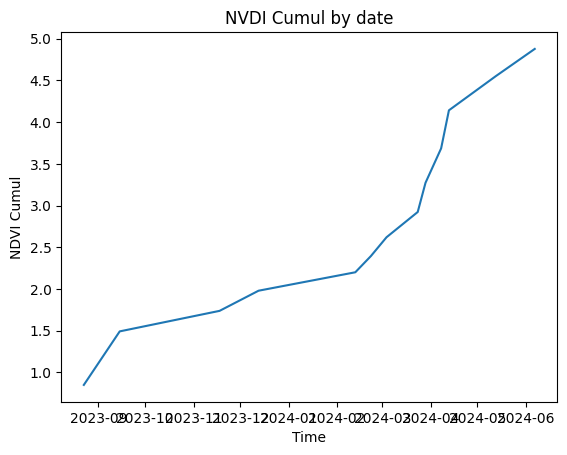

In [19]:
# Display cumulative NDVI from last result

import numpy as np
import matplotlib.pyplot as plt

polygon_ndvi_ds = ndvi_time_series_xarr['ndvi'].sortby('time')
time_coords = polygon_ndvi_ds['time']

# exclude Nan values to caluculate mean
masked_dataarray = polygon_ndvi_ds.where(~np.isnan(polygon_ndvi_ds))

# NDVI mean calculattion
mean_ndvi = masked_dataarray.mean(dim=['x', 'y'])

# Cumulative NDVI calculation 
polygon_cumul_ndvi = mean_ndvi.cumsum(dim='time')
polygon_cumul_ndvi 

# build & display cumlative Ndvi graph
plt.plot(time_coords, polygon_cumul_ndvi)
plt.xlabel('Time')
plt.ylabel('NDVI Cumul')
plt.title('NVDI Cumul by date')
plt.show()

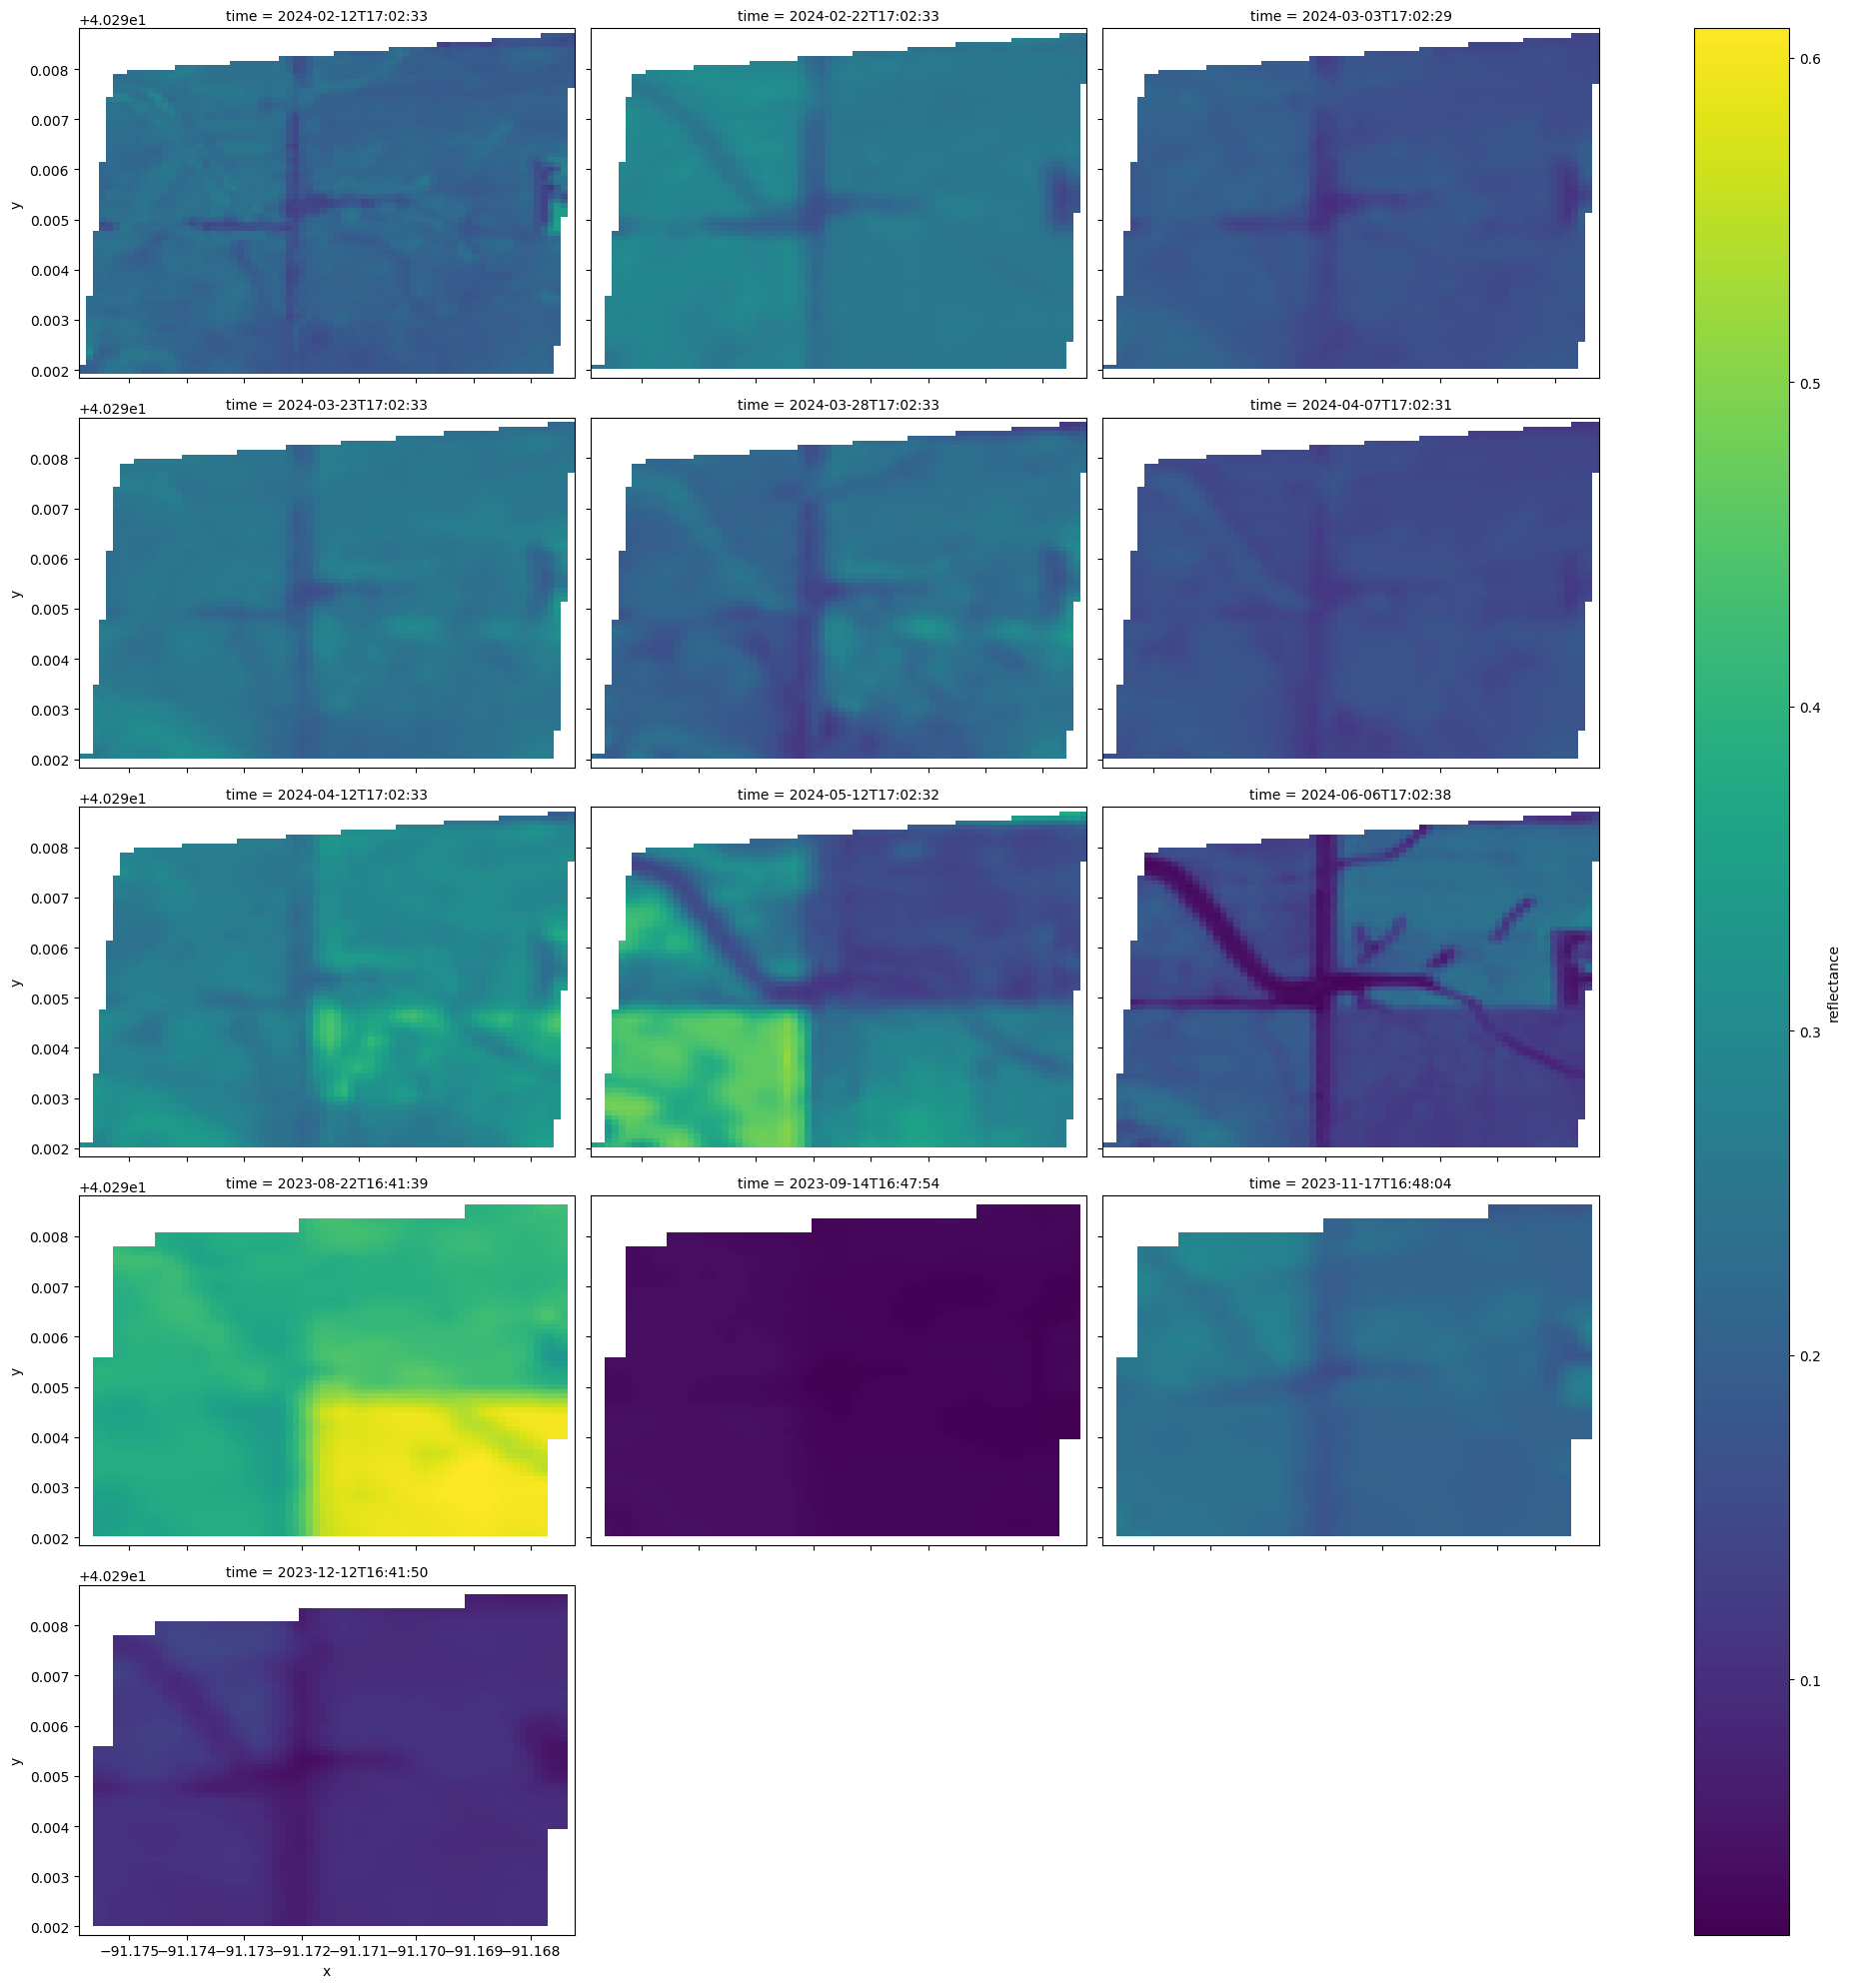

In [20]:
import matplotlib
time_series_xarr.reflectance.clip(0,1).sel(band='Green').plot(x="x", y="y", col="time", col_wrap=3, figsize=(20,20))

In [21]:
images_references

{('2024-06-06T17:02:38Z',
  'SENTINEL_2'): <geosyspy.image_reference.ImageReference at 0x280e7be3b10>,
 ('2024-05-28T16:41:01Z',
  'LANDSAT_9'): <geosyspy.image_reference.ImageReference at 0x280cf0460d0>,
 ('2024-05-12T17:02:32Z',
  'SENTINEL_2'): <geosyspy.image_reference.ImageReference at 0x280e7be2bd0>,
 ('2024-05-12T16:41:14Z',
  'LANDSAT_9'): <geosyspy.image_reference.ImageReference at 0x280cf06a950>,
 ('2024-04-12T17:02:33Z',
  'SENTINEL_2'): <geosyspy.image_reference.ImageReference at 0x280e7bcfed0>,
 ('2024-04-07T17:02:31Z',
  'SENTINEL_2'): <geosyspy.image_reference.ImageReference at 0x280e7be3410>,
 ('2024-03-28T17:02:33Z',
  'SENTINEL_2'): <geosyspy.image_reference.ImageReference at 0x280cf079710>,
 ('2024-03-23T17:02:33Z',
  'SENTINEL_2'): <geosyspy.image_reference.ImageReference at 0x280e7be2110>,
 ('2024-03-09T16:41:51Z',
  'LANDSAT_9'): <geosyspy.image_reference.ImageReference at 0x280cf07abd0>,
 ('2024-03-03T17:02:29Z',
  'SENTINEL_2'): <geosyspy.image_reference.ImageRe

In [23]:
# Download and save a specific image
season_field_id = 'y3mxlxx'
image_id = 'sentinel-2-l2a|S2B_21JYM_20240429_0_L2A'
indicator = 'INSEASON_NDVI'
client.download_image(season_field_id, None, image_id, indicator)


2024-06-14 11:20:04,351 - geosyspy.geosys - INFO - writing to c:\Users\ajd\Documents\GitHub\GeosysPy\image_sentinel-2-l2a_S2B_21JYM_20240429_0_L2A_tiff.zip


In [24]:
# Define a data schema in Analytics Fabrics
schema = {
    "NDVI": "double"
}
schema_id = "GeosysPy_NDVI"
client.create_schema_id(schema_id, schema)

2024-06-14 11:20:08,479 - geosyspy.services.analytics_fabric_service - INFO - The schema GeosysPy_NDVI already exists.


In [25]:
# Get metrics in Analytics Fabric

start_date = dt.datetime.strptime("2022-01-24", "%Y-%m-%d")
end_date = dt.datetime.strptime("2022-03-01", "%Y-%m-%d")
schema_id = "LAI_RADAR"
polygon = "POLYGON((-52.72591542 -18.7395779,-52.72604885 -18.73951122,-52.72603114 -18.73908689,-52.71556835 -18.72490316,-52.71391916 -18.72612966,-52.71362802 -18.72623726,-52.71086473 -18.72804231,-52.72083542 -18.74173696,-52.72118937 -18.74159174,-52.72139229 -18.7418552,-52.72600257 -18.73969719,-52.72591542 -18.7395779))"
client.get_metrics( schema_id, start_date, end_date,polygon=polygon)

2024-06-14 11:20:08,985 - geosyspy.services.analytics_fabric_service - INFO - Calling APIs for metrics
2024-06-14 11:20:09,222 - geosyspy.services.analytics_fabric_service - INFO - No metrics found in Analytic Fabric with SchemaId: LAI_RADAR, SeasonField:mUPLeUseMwsGMQ3ugs7xE between:2022-01-24 and 2022-03-01  


""


In [26]:
# Get time serie
start_date = dt.datetime.strptime("2018-12-30", "%Y-%m-%d")
end_date = dt.datetime.strptime("2019-12-31", "%Y-%m-%d")
df = client.get_time_series(start_date, end_date, collection=SatelliteImageryCollection.MODIS, indicators=["NDVI"],polygon=polygon)
df.head()

2024-06-14 11:20:09,524 - geosyspy.services.vegetation_time_series_service - INFO - Calling APIs for aggregated time series
c:\Users\ajd\Documents\GitHub\GeosysPy\geosyspy\services\vegetation_time_series_service.py:57: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json.dumps(dict_response))


,index,value
date,,
2018-12-30,NDVI,0.881439
2018-12-31,NDVI,0.879117
2019-01-01,NDVI,0.876899
2019-01-02,NDVI,0.874825
2019-01-03,NDVI,0.872929


In [27]:
# Create structure before push values in Analytics Fabrics
values = []
for i in range(0,len(df)):
    prop = {
        "Timestamp": str(df["value"].index[i]),
        "Values": {
            "NDVI": df["value"].values[i]
        }
        }
    values.append(prop)
values[0:5]

[{'Timestamp': '2018-12-30 00:00:00', 'Values': {'NDVI': 0.88143934}},
 {'Timestamp': '2018-12-31 00:00:00', 'Values': {'NDVI': 0.8791165400000001}},
 {'Timestamp': '2019-01-01 00:00:00', 'Values': {'NDVI': 0.87689914}},
 {'Timestamp': '2019-01-02 00:00:00', 'Values': {'NDVI': 0.8748249100000001}},
 {'Timestamp': '2019-01-03 00:00:00', 'Values': {'NDVI': 0.87292918}}]

In [28]:
# Push metrics in Analytics Fabrics
schema_id = "GeosysPy_NDVI"
client.push_metrics(schema_id, values, polygon=polygon)

200

In [29]:
# Get metrics in Analytics Fabrics
start_date = dt.datetime.strptime("2018-01-01", "%Y-%m-%d")
end_date = dt.datetime.strptime("2022-04-01", "%Y-%m-%d")
client.get_metrics(schema_id, start_date, end_date, polygon=polygon)

2024-06-14 11:20:20,051 - geosyspy.services.analytics_fabric_service - INFO - Calling APIs for metrics


,Values.NDVI,Schema.Id
date,,
2018-12-30T00:00:00Z,0.881439,GeosysPy_NDVI
2018-12-31T00:00:00Z,0.879117,GeosysPy_NDVI
2019-01-01T00:00:00Z,0.876899,GeosysPy_NDVI
2019-01-02T00:00:00Z,0.874825,GeosysPy_NDVI
2019-01-03T00:00:00Z,0.872929,GeosysPy_NDVI
...,...,...
2019-04-02T00:00:00Z,0.388090,GeosysPy_NDVI
2019-04-03T00:00:00Z,0.385102,GeosysPy_NDVI
2019-04-04T00:00:00Z,0.382602,GeosysPy_NDVI


In [30]:
start_date="2020-10-09"
end_date="2022-10-09"
sensors=["Sentinel_2", "Landsat_8"]
denoiser=True
smoother="ww"
eoc=True
aggregation="mean"
index="ndvi"
raw_data=True
str_polygon="POLYGON ((-0.49881816 46.27330504, -0.49231649 46.27320122, -0.49611449 46.26983426, -0.49821735 46.27094671, -0.49881816 46.27330504))"

str_s3_path = client.get_mr_time_series(str_polygon, start_date, end_date, sensors, denoiser, smoother, eoc, aggregation, index, raw_data)
str_s3_path

2024-06-14 11:20:21,682 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:20:23,934 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running


's3://geosys-geosys-us/2tKecZgMyEP6EkddLxa1gV/mrts/5f2141ab13324d6abab1df96a2ad4316'

In [31]:
str_polygon="POLYGON ((-0.49881816 46.27330504, -0.49231649 46.27320122, -0.49611449 46.26983426, -0.49821735 46.27094671, -0.49881816 46.27330504))"

str_s3_path = client.get_mr_time_series(str_polygon)
str_s3_path

2024-06-14 11:20:29,099 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:20:31,237 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:20:35,400 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running


's3://geosys-geosys-us/2tKecZgMyEP6EkddLxa1gV/mrts/3234ad205d9d45a398c9153c3d1753b8'

In [32]:
from notebook_utils import *

# read MRTS outputs from AWS and plot result
dict_mrts = read_mrts_from_awsS3(str_s3_path)
plot_mrts_dict(dict_mrts)

### others useful functions
# plot_mrts_from_aws(str_s3_path) : plot MRTS outputs from AWS
# download MRTS outputs from AWS and read outputs downloaded : download_s3_files(str_s3_path), read_mrts_data(str_downloaded_path)

ClientError: An error occurred (InvalidToken) when calling the ListObjects operation: The provided token is malformed or otherwise invalid.

## AGRIQUEST COMPUTATION

In [33]:
# Generate a panda data frame from Agriquest Weather Data:
# on all AMU of o block
# on a specific period
# for a specific weather indicator
aq_weather_data_frame = client.get_agriquest_weather_block_data(start_date="2022-06-01",
                                                  end_date="2023-06-10",
                                                  block_code=AgriquestBlocks.AMU_NORTH_AMERICA,
                                                  weather_type=AgriquestWeatherType.AVERAGE_TEMPERATURE)

aq_weather_data_frame

c:\Users\ajd\Documents\GitHub\GeosysPy\geosyspy\services\agriquest_service.py:99: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json.dumps(dict_response))


1,AMU,X,Y,Area (km2),Start,End,Value(Fahrenheit)
2,dm6zd7,-120.609779853754,50.1815140859714,2076206.19350909,06/01/22,06/10/23,42.6537761214063
3,pm71ed,-116.26967229539,49.3142983301064,1140818.84899762,06/01/22,06/10/23,40.9050440207924
4,37ndaz,-121.431647767903,50.8957142214965,859701.520677822,06/01/22,06/10/23,41.1429031374504
5,apx5rz,-121.101796289793,49.5280358248754,849852.287689543,06/01/22,06/10/23,40.4459632826831
6,mp6qwd,-119.253577028055,50.1638042845403,1371497.13784112,06/01/22,06/10/23,43.2356649016597
...,...,...,...,...,...,...,...
2937,7zrznz,-77.0172633740488,38.9080077311573,42925.0353570637,06/01/22,06/10/23,59.7459764343867
2938,ldgd6n,-71.5907951395792,41.6946227800715,620540.139719753,06/01/22,06/10/23,54.7409374010456
2939,1kwkj7,-71.2771619559509,41.5393927681328,25993.6751949394,06/01/22,06/10/23,54.7747722154322
2940,z5r5ke,-71.37775593944,41.514830063034,6405.03372192102,06/01/22,06/10/23,54.764876751904


In [34]:
# Generate a panda data frame from Agriquest NDVI Data:
# on all AMU of o block
# on a specific date
# for a specific commodity (ALL_VEGETATION or ALL_CROPS)

aq_ndvi_data_frame = client.get_agriquest_ndvi_block_data(day_of_measure="2022-06-01",
                                               commodity_code=AgriquestCommodityCode.ALL_CROPS,             
                                               block_code=AgriquestBlocks.FRA_DEPARTEMENTS)

aq_ndvi_data_frame

c:\Users\ajd\Documents\GitHub\GeosysPy\geosyspy\services\agriquest_service.py:149: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json.dumps(dict_response))


1,AMU,X,Y,Area (km2),Start,End,NDVI
2,Aude,2.41362224200849,43.1032535837836,1567533.41901905,06/01/22,06/01/22,0.67292565
3,Haute-Loire,3.80629821371942,45.128115177836,1236418.34584859,06/01/22,06/01/22,0.7676143
4,Bouches-du-Rhône,5.08604203461634,43.5432739455779,1295740.4639529,06/01/22,06/01/22,0.5370673
5,Lot-et-Garonne,0.460747437025639,44.3679636789425,1330771.26129295,06/01/22,06/01/22,0.6660436
6,Creuse,2.01822963286571,46.0906204404038,1383585.42233085,06/01/22,06/01/22,0.7965648
...,...,...,...,...,...,...,...
79,Alpes-de-Haute-Provence,6.24465390599831,44.1061172758651,1728081.03437926,06/01/22,06/01/22,0.66969323
80,Morbihan,-2.81218268011372,47.8475865265542,1693893.7322425,06/01/22,06/01/22,0.71398413
81,Doubs,6.36272222421339,47.1659635940096,1298913.913808,06/01/22,06/01/22,0.8028164
82,Jura,5.69737730693424,46.7293599950923,1247558.25175067,06/01/22,06/01/22,0.80481243


## ANALYTICS COMPUTATION

In [35]:
# Analytics processor - Historical Harvest
harvest_historical_analytics = client.get_harvest_analytics(
    season_duration=215,
    season_start_day=1,
    season_start_month=4,
    crop=crops._2ND_CORN,
    year=2021,
    geometry="POLYGON ((-56.785919346530768 -21.208154463301554 ,  -56.79078750820733 -21.206043784434833 ,  -56.790973809206818 -21.206069651656232 ,  -56.791373799079636 -21.197107091323097 ,  -56.785129186971687 -21.196010916846863 ,  -56.781397554331065 -21.19535575112814 ,  -56.777108478217059 -21.202038412606473 ,  -56.778435977920665 -21.211398619037478 ,  -56.785919346530768 -21.208154463301554))",
    harvest_type=Harvest.HARVEST_HISTORICAL)
harvest_historical_analytics


AttributeError: _2ND_CORN

In [36]:
# Analytics processor - Inseason Harvest
harvest_in_season_analytics = client.get_harvest_analytics(
    season_duration=215,
    season_start_day=1,
    season_start_month=4,
    crop=crops._2ND_CORN,
    year=2021,
    geometry="POLYGON ((-56.785919346530768 -21.208154463301554 ,  -56.79078750820733 -21.206043784434833 ,  -56.790973809206818 -21.206069651656232 ,  -56.791373799079636 -21.197107091323097 ,  -56.785129186971687 -21.196010916846863 ,  -56.781397554331065 -21.19535575112814 ,  -56.777108478217059 -21.202038412606473 ,  -56.778435977920665 -21.211398619037478 ,  -56.785919346530768 -21.208154463301554))",
    harvest_type=Harvest.HARVEST_IN_SEASON)

harvest_in_season_analytics


AttributeError: _2ND_CORN

In [ ]:
# Analytics processor - Inseason Emergence
emergence_in_season_analytics = client.get_emergence_analytics(
    season_duration=215,
    season_start_day=1,
    season_start_month=4,
    crop=crops._2ND_CORN,
    year=2021,
    geometry="POLYGON ((-56.785919346530768 -21.208154463301554 ,  -56.79078750820733 -21.206043784434833 ,  -56.790973809206818 -21.206069651656232 ,  -56.791373799079636 -21.197107091323097 ,  -56.785129186971687 -21.196010916846863 ,  -56.781397554331065 -21.19535575112814 ,  -56.777108478217059 -21.202038412606473 ,  -56.778435977920665 -21.211398619037478 ,  -56.785919346530768 -21.208154463301554))",
    emergence_type=Emergence.EMERGENCE_IN_SEASON)

emergence_in_season_analytics


In [ ]:
# Analytics processor - Historical Emergence
emergence_historical_analytics = client.get_emergence_analytics(
    season_duration=215,
    season_start_day=1,
    season_start_month=4,
    crop=crops._2ND_CORN,
    year=2021,
    geometry="POLYGON ((-56.785919346530768 -21.208154463301554 ,  -56.79078750820733 -21.206043784434833 ,  -56.790973809206818 -21.206069651656232 ,  -56.791373799079636 -21.197107091323097 ,  -56.785129186971687 -21.196010916846863 ,  -56.781397554331065 -21.19535575112814 ,  -56.777108478217059 -21.202038412606473 ,  -56.778435977920665 -21.211398619037478 ,  -56.785919346530768 -21.208154463301554))",
    emergence_type=Emergence.EMERGENCE_HISTORICAL)

emergence_historical_analytics


In [37]:
# Analytics processor - Emergence Delay
emergence_delay_analytics = client.get_emergence_analytics(
    season_duration=215,
    season_start_day=1,
    season_start_month=4,
    crop=crops.CORN,
    year=2021,
    geometry="POLYGON ((-56.785919346530768 -21.208154463301554 ,  -56.79078750820733 -21.206043784434833 ,  -56.790973809206818 -21.206069651656232 ,  -56.791373799079636 -21.197107091323097 ,  -56.785129186971687 -21.196010916846863 ,  -56.781397554331065 -21.19535575112814 ,  -56.777108478217059 -21.202038412606473 ,  -56.778435977920665 -21.211398619037478 ,  -56.785919346530768 -21.208154463301554))",
    emergence_type=Emergence.EMERGENCE_DELAY)

emergence_delay_analytics


2024-06-14 11:21:54,660 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:21:56,797 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:22:00,941 - geosyspy.services.analytics_fabric_service - INFO - Calling APIs for Latest metrics
2024-06-14 11:22:01,103 - geosyspy.services.analytics_fabric_service - INFO - No Latest metrics found in Analytic Fabric with SchemaId: EMERGENCE_DELAY, SeasonField:2Kh2c4sGy2EkTXQv4LRWv2 


""


In [38]:
# Analytics processor - Potential Score
potential_score_analytics = client.get_potential_score_analytics(
    end_date = "2022-03-06",
    nb_historical_years = 5,
    season_duration = 200, 
    season_start_day = 1, 
    season_start_month = 10, 
    crop = crops.CORN,
    sowing_date = "2021-10-01",
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
)

potential_score_analytics

Exception: Task Status: Error, Content: b'{"events":[{"level":"Information","date":"2024-06-14T09:22:01.912Z","source":"Analytics.geosys-analyticsprocessors-webapi","message":"Processor called","eventData":{"TaskId":"cde93d016b1c4625bc12b648603d2f79","Error":null}},{"level":"Information","date":"2024-06-14T09:22:01.955Z","source":"AnalyticsProcessor.InseasonPotentialScore","message":"Processor started"},{"level":"Error","date":"2024-06-14T09:22:01.999Z","source":"AnalyticsProcessor.InseasonPotentialScore","message":"Unhandled exception","eventData":{"error":"KeyError","message":"\'toi\'","stackTrace":"Traceback (most recent call last):\\n  File \\"/cloudevents_endpoint.py\\", line 109, in __start_task\\n    results = main(data)\\n  File \\"/main.py\\", line 19, in main\\n    model = get_model(input_json[\'parameters\'])\\n  File \\"/main.py\\", line 13, in get_model\\n    model = predict_model.HistoricalPotentialScore(input_json_parameters)\\n  File \\"/historicalpotentialscore/models/predict_model.py\\", line 210, in __init__\\n    self.load_dates()\\n  File \\"/historicalpotentialscore/models/predict_model.py\\", line 248, in load_dates\\n    self.season = Season(**self.parameters[\'toi\'][\'season\'])\\nKeyError: \'toi\'\\n"}}],"id":"cde93d016b1c4625bc12b648603d2f79","taskId":"cde93d016b1c4625bc12b648603d2f79","processorCode":"potential_score","userId":"2tKecZgMyEP6EkddLxa1gV","userLogin":"ETotain_US","customerCode":"GEOSYS_US","parametersProfile":{"code":"potential_score_default"},"parameters":{"nb_historical_years":5,"threshold":0.7,"season_duration":200,"season_start_day":1,"season_start_month":10,"end_date":"2022-03-06"},"status":"Error","createdAt":"2024-06-14T09:22:01.654Z","modifiedAt":"2024-06-14T09:22:01.999Z","duration":0}'

In [39]:
# Analytics processor - Greenness
greenness_analytics = client.get_greenness_analytics(
    start_date ="2022-01-15",
    end_date = "2022-05-31",    
    crop = crops.CORN,
    sowing_date = "2022-01-15",
    # WKT
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
    # GeoJson
    #geometry='{"type": "Polygon","coordinates": [[[ -54.260277780000003, -25.387777780000000 ],[ -54.260277780000003, -25.374444440000001 ],[ -54.259999999999998, -25.374166670000001 ],[ -54.259722220000000, -25.374444440000001 ],[ -54.259444440000003, -25.374444440000001 ],[ -54.258888890000001, -25.374722219999999 ],[ -54.258611110000004, -25.374722219999999 ],[ -54.258888890000001, -25.375000000000000 ],[ -54.258888890000001, -25.375555550000001 ],[ -54.258611110000004, -25.376111110000000 ],[ -54.258611110000004, -25.381944440000002 ],[ -54.258333329999999, -25.384166669999999 ],[ -54.256944439999998, -25.383611110000000 ],[ -54.256944439999998, -25.384166669999999 ],[ -54.257500000000000, -25.384166669999999 ],[ -54.257500000000000, -25.384444439999999 ],[ -54.257777779999998, -25.384166669999999 ],[ -54.258070160000003, -25.384158120000002 ],[ -54.258055560000003, -25.384444439999999 ],[ -54.258077300000004, -25.384722060000001 ],[ -54.257500000000000, -25.385277779999999 ],[ -54.256944439999998, -25.385000000000002 ],[ -54.256388890000004, -25.383611110000000 ],[ -54.254722219999998, -25.383055550000002 ],[ -54.254722219999998, -25.382500000000000 ],[ -54.254166670000004, -25.381944440000002 ],[ -54.254444440000000, -25.381666670000001 ],[ -54.254722219999998, -25.381666670000001 ],[ -54.254722219999998, -25.379444440000000 ],[ -54.252777780000002, -25.379444440000000 ],[ -54.252777780000002, -25.385833330000001 ],[ -54.254192230000001, -25.386153900000000 ],[ -54.253906700000002, -25.385892160000001 ],[ -54.253888889999999, -25.385000000000002 ],[ -54.254444440000000, -25.385555549999999 ],[ -54.254787100000001, -25.385820770000002 ],[ -54.254722219999998, -25.386111110000002 ],[ -54.260277780000003, -25.387777780000000 ]]]}',
)

greenness_analytics

2024-06-14 11:22:36,673 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:22:38,822 - geosyspy.services.analytics_fabric_service - INFO - Calling APIs for Latest metrics


,Values.peak_found,Values.max_NDVI_val,Values.max_NDVI_date,Schema.Id
date,,,,
2024-06-14T09:22:37.178Z,True,0.914025,2022-03-29,GREENNESS


In [40]:
# Analytics processor - Harvest Readiness
harvest_readiness_analytics = client.get_harvest_readiness_analytics(
    start_date ="2022-01-15",
    end_date = "2022-05-31",    
    crop = crops.CORN,
    sowing_date = "2022-01-15",
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
)

harvest_readiness_analytics

2024-06-14 11:22:40,746 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:22:43,005 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:22:47,205 - geosyspy.services.analytics_fabric_service - INFO - Calling APIs for Latest metrics


,Values.date,Schema.Id
date,,
2024-06-14T09:22:43.483Z,2022-05-10,HARVEST_READINESS


In [41]:
# Analytics processor - Planted area
planted_area_analytics = client.get_planted_area_analytics(
    start_date ="2022-01-15",
    end_date = "2022-05-31",        
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
)

planted_area_analytics

2024-06-14 11:22:48,424 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running


Exception: Task Status: Error, Content: b'{"events":[{"level":"Information","date":"2024-06-14T09:22:48.124Z","source":"Analytics.geosys-analyticsprocessors-webapi","message":"Processor called","eventData":{"TaskId":"4518fc68b58f45978ff1f5f4c93ddc0b","Error":null}},{"level":"Information","date":"2024-06-14T09:22:48.141Z","source":"AnalyticsProcessor.PlantedArea","message":"Processor started"},{"level":"Information","date":"2024-06-14T09:22:49.861Z","source":"AnalyticsProcessor.PlantedArea","message":"Computation finished"},{"level":"Information","date":"2024-06-14T09:22:49.871Z","source":"AnalyticsProcessor.PlantedArea","message":"Format results for the callback"},{"level":"Information","date":"2024-06-14T09:22:49.881Z","source":"AnalyticsProcessor.PlantedArea","message":"Callback called"},{"level":"Error","date":"2024-06-14T09:22:49.957Z","source":"AnalyticsProcessor.PlantedArea","message":"Error while sending results to Analytics Fabric","eventData":{"error":"{\\n  \\"Errors\\": {\\n    \\"\\": {\\n      \\"\\": [\\n        {\\n          \\"Code\\": \\"BadRequest\\",\\n          \\"Message\\": \\"Property \'planted_area\' with value \'\' cannot be null. Property \'planted_percentage\' with value \'\' cannot be null. \\"\\n        }\\n      ]\\n    }\\n  },\\n  \\"Code\\": \\"model_validation_error\\",\\n  \\"Message\\": \\"Bad request: see the Errors field for details\\"\\n}"}},{"level":"Error","date":"2024-06-14T09:22:49.978Z","source":"AnalyticsProcessor.PlantedArea","message":"Unhandled exception","eventData":{"error":"Exception","message":"Error while sending results to Analytics Fabric","stackTrace":"Traceback (most recent call last):\\n  File \\"/cloudevents_endpoint.py\\", line 112, in __start_task\\n    __process_callback(results, context)\\n  File \\"/cloudevents_endpoint.py\\", line 133, in __process_callback\\n    cloudevent_endpoint_callback(formatted_results, context)\\n  File \\"/cloudevents_endpoint_callback.py\\", line 22, in cloudevent_endpoint_callback\\n    __send_to_analytics_fabrik(process_results, context)\\n  File \\"/cloudevents_endpoint_callback.py\\", line 52, in __send_to_analytics_fabrik\\n    raise Exception(\\"Error while sending results to Analytics Fabric\\")\\nException: Error while sending results to Analytics Fabric\\n"}}],"id":"4518fc68b58f45978ff1f5f4c93ddc0b","taskId":"4518fc68b58f45978ff1f5f4c93ddc0b","processorCode":"planted_area","userId":"2tKecZgMyEP6EkddLxa1gV","userLogin":"ETotain_US","customerCode":"GEOSYS_US","parametersProfile":{"code":"planted_area_default"},"parameters":{"threshold":30},"status":"Error","createdAt":"2024-06-14T09:22:48.048Z","modifiedAt":"2024-06-14T09:22:49.978Z","duration":1}'

In [42]:
# Analytics processor - zarc
zarc_analytics = client.get_zarc_analytics(
    start_date_emergence= "2022-01-15",
    end_date_emergence = "2022-05-31",
    nb_days_sowing_emergence = 20,
    crop =crops.CORN,    
    soil_type = ZarcSoilType.NONE,
    cycle = ZarcCycleType.NONE,    
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
)

zarc_analytics

c:\Users\ajd\Documents\GitHub\GeosysPy\.venv\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gis-services-pp.geosys.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2024-06-14 11:23:12,693 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:23:14,847 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:23:19,041 - geosyspy.services.analytics_fabric_service - INFO - Calling APIs for Latest metrics


,Values.emergence_date,Values.sowing_date,Values.zarc_start_date,Values.zarc_end_date,Values.status,Schema.Id
date,,,,,,
2024-06-14T09:23:14Z,2022-02-17,2022-01-28,2023-08-01,2023-12-31,False,ZARC


In [43]:
# Analytics processor - crop id
brazil_crop_id_analytics = client.get_brazil_crop_id_analytics(
    start_date ="2020-10-01",
    end_date = "2021-05-31",    
    season = CropIdSeason.SEASON_1,
    geometry="POLYGON ((-54.26027778 -25.38777778, -54.26027778 -25.37444444, -54.26 -25.37416667, -54.25972222 -25.37444444, -54.25944444 -25.37444444, -54.25888889 -25.37472222, -54.258611110000004 -25.37472222, -54.25888889 -25.375, -54.25888889 -25.37555555, -54.258611110000004 -25.37611111, -54.258611110000004 -25.38194444, -54.25833333 -25.38416667, -54.25694444 -25.38361111, -54.25694444 -25.38416667, -54.2575 -25.38416667, -54.2575 -25.38444444, -54.25777778 -25.38416667, -54.25807016 -25.384158120000002, -54.25805556 -25.38444444, -54.258077300000004 -25.38472206, -54.2575 -25.38527778, -54.25694444 -25.385, -54.256388890000004 -25.38361111, -54.25472222 -25.38305555, -54.25472222 -25.3825, -54.254166670000004 -25.38194444, -54.25444444 -25.38166667, -54.25472222 -25.38166667, -54.25472222 -25.37944444, -54.25277778 -25.37944444, -54.25277778 -25.38583333, -54.25419223 -25.3861539, -54.2539067 -25.38589216, -54.25388889 -25.385, -54.25444444 -25.38555555, -54.2547871 -25.385820770000002, -54.25472222 -25.38611111, -54.26027778 -25.38777778))"
)

brazil_crop_id_analytics

2024-06-14 11:23:25,705 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:23:27,853 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:23:32,057 - geosyspy.services.analytics_processor_service - INFO - Retry -- Task still running
2024-06-14 11:23:40,241 - geosyspy.services.analytics_fabric_service - INFO - Calling APIs for Latest metrics


,Values.crop_code,Values.crop_probability,Schema.Id
date,,,
2024-06-14T09:23:32.87Z,SOYBEANS,"{""CORN"": 0.053, ""SOYBEANS"": 0.933, ""SUGARCANE""...",CROP_IDENTIFICATION


In [44]:
import pandas as pd

# Display probability by crop value from last zarc analytics result
data_dict = eval(brazil_crop_id_analytics.values[0][1])
df_new = pd.DataFrame.from_records([data_dict])
df_new


,CORN,SOYBEANS,SUGARCANE
0,0.053,0.933,0.013
